# Report for 2D Project Physical World and Digital World

Cohort: #5

Team No.: #8

Members:
* Loh Jian An Lionell (Student ID)
* Celine Yee Se Lin (Student ID)
* Claire Tan 
* Zhao Wen Qiang 
* Cheow Yi Jian


# Introduction

Temperature sensors need to reach quasi-thermal equilibrium with the environment in order to measure its temperature accurately. The time taken to reach thermal equilibrium however can be a long wait. For instance, the sensor originally at room temperature takes more than 70 seconds before it is able to reflect the temperature of a water bath at 60 deg celsius. This 70 seconds was the time taken for the sensor to reach quasi-thermal equilibrium with the water bath. 

In order to expedite this process, we augment the hardware with predictive programmes. More specfically, we build a predictive model with training data with Machine Learning algorithms. Using this predictive model, we are able to take raw sensor data from the first 10 seconds to give an accurate temperature of the water bath, with an average standard deviation of 1%.  

Write your introduction here. Describe the problem you want to solve and a brief of your approach and summary of your result.


# Description of Data from Experiment

## Data Collection

### Concerns about Time and Space
The collection of data was done with the temperature sensor attached to a Raspberry Pi in the classroom.
The location for data collection is not trivial as each location has unique environment variables that must be kept as consistent as possible at the point of prediction. 

For example, the ambient temperature of the classroom is 0.7 degree cooler than the temperature beside the pantry. Even within the classroom, the temperature at night is 0.4 degree warmer than the temperature in the day, as the air conditioners are switched off at night. 

Since the conditions for data collection can be controlled, our group decided to make special arrangements to collect our data in the day, in the classroom, to keep external variables as consistent as possible. While deviation of such variables might be small, if they are not kept constant, we might still have to factor them in as "features" to train our model, which complicates the process.

### Collection Method 
We printed the temperature on the Python3 Shell and saved the Shell outputs as a text file for processing thereafter. We opted for this method as we realised that writing the values to a csv file somehow slowed down the temperature reading interval by 0.08 seconds. This could be due to the additional processing overhead when writing data to files that is especially significant considering the limited RAM of the RPi3. 






## Data Preparation

When preparing the data, we want to make sure that there is no "noise" in the data due to imperfect execution. To be sure, we decided to visualise the data. 

The code below processes the text file, creates two lists of data - one for time interval and the other for temperatures. We then plot the temperature data against the time intervals.

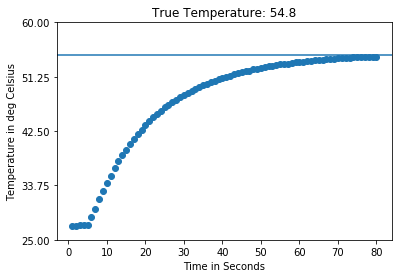

In [263]:
import matplotlib.pyplot as plt
import numpy as np

def processfile(file_object):
    time_s = list(np.linspace(1,80, 80))
    temp = []
    for line in file_object:
        try:
            t = line.split(",")
            T_float = float(t[0][1:])
            temp.append(T_float)
        except: 
            
            t = line.split(" ")
            T_float = float(t[0])
            temp.append(T_float)
            
    return time_s, temp
        
f = open("./Data_54.8.txt", "r")
time_s, temp = processfile(f)

plt.title("True Temperature: 54.8")
plt.xlabel("Time in Seconds")
plt.ylabel("Temperature in deg Celsius")
plt.scatter(time_s, temp[:80])
plt.xticks()
plt.yticks(list(np.linspace(25,60, 5)))
plt.axhline(54.8)
plt.show()

With the visualisation plot above, we can see that there was a significant delay in inserting the temperature sensor. Taking the the first few data points would thus misguide our model. We then went to manually erase the data that was a result of bad execution. 

Another insight we gained was that during prediction, there might be similar instances of lag time. This insight made systematically exclude the first few seconds of data collecte by the sensor during prediction. 

## Data Format

We realised how the temperature of the sensor changes with time might be a function of the actual temperature of the water bath. This corresponds with our Physical World knowledge that rate of thermal conduction is a function of the temperature difference. The greater the difference between the water bath temperature and the sensor, the faster the sensor gains heat and the faster the readings increase.

We thus wanted to test if the gradient of the temperate-time graph has a correlation with the true temperature of the water bath. Our hypothesis was that the higher the value of the gradient (the steeper the gradient) the higher the actual temperature of the water bath.

### Finding Gradient 
To find the gradient of the temperature-time graph, we used linear regression on the temperature time graph take the gradient of the line to be the gradient of the temperature-time graph. In this context, the gradient, refers to the average rate of change of temperature. 

To find the best-fit line, we use the curve_fit function from scipy.optimize.

The gradient for 54.8 deg for the first 25 points is 0.8487415384612085


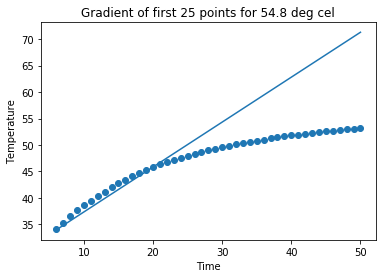

In [264]:
from scipy.optimize import curve_fit

def func(x, m, c):
        return m*x + c


f = open("54.8.txt", "r")
time_s, temp = processfile(f)

def find_gradient(temp, points):
    
    time_s = np.linspace(1,30, 30)
    params, extras = curve_fit(func, time_s[:points], temp[:points])
    return params[0], params[1]

gradient, intercept = find_gradient(temp, 25)
print("The gradient for 54.8 deg for the first 25 points is {}".format(gradient))

plt.scatter(time_s[5:50], temp[5:50])
plt.plot(time_s[5:50], [func(t, gradient, intercept) for t in time_s[5:50]])
plt.title("Gradient of first 25 points for 54.8 deg cel")
plt.xlabel("Time")
plt.ylabel("Temperature")

plt.show()



The code above finds the gradient for the first 25 points of data for one temperature of water bath. This is the maximum number of data we may collect, as our temperature sensor collects data at 1 second interval and our aim is to achieve prediction in 25 seconds or less.

We then find the gradient for all our training data sets with the code below. 

In [309]:
import glob
files = glob.glob("TrainingData/*")

real_temps = []
gradients = []

for file in sorted(files):
    real_temp = float(file[13:17])
    f = open(file, 'r')
    temps = processfile(f)[1]
    gradient, intercept = find_gradient(temps, 20)
    real_temps.append(real_temp)
    gradients.append(gradient)
    print("The gradient for temperature: {} is {}".format(real_temp, gradient))
    

The gradient for temperature: 10.7 is -0.5134541353416469
The gradient for temperature: 14.8 is -0.3970857142887616
The gradient for temperature: 16.8 is -0.3839248120330938
The gradient for temperature: 21.1 is -0.1766766917318907
The gradient for temperature: 24.7 is -0.06611428501487446
The gradient for temperature: 30.4 is 0.09064060150177644
The gradient for temperature: 33.5 is 0.19721278195313618
The gradient for temperature: 35.0 is 0.2000135338328417
The gradient for temperature: 44.3 is 0.5703127812932269
The gradient for temperature: 47.3 is 0.5748195488712531
The gradient for temperature: 48.3 is 0.636572180450335
The gradient for temperature: 50.8 is 0.7058894735706017
The gradient for temperature: 59.9 is 0.9694172932330161


### Determining the strength of Linear Correlation
Now that we have collated the gradients for different temperatures of the water bath, we visualised it by plotting a graph of "Temperature of Water Bath" against "Gradient". 

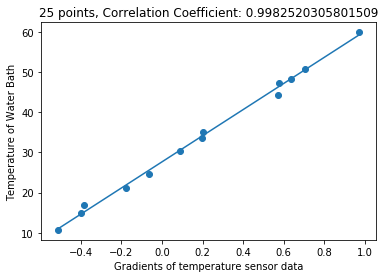

In [310]:
from scipy.stats import pearsonr

correlation = pearsonr(gradients, real_temps)

params, extras = curve_fit(func, gradients, real_temps)

plt.scatter(gradients, real_temps)
plt.plot(gradients, [func(gradient, *params) for gradient in gradients])
plt.xlabel("Gradients of temperature sensor data")
plt.ylabel("Temperature of Water Bath")
plt.title("{} points, Correlation Coefficient: {}".format(25, correlation[0]))

plt.show()



### Insights from results


Visually, we can see that the there is a strong linear coefficient. Numerically the Correlation coefficient is 0.9981369536393054, which is very close to 1. This suggests a strong linear correlation between Temperature of Water Bath and the Gradients of the temperature sensor data. With this as validation of our hypothesis, we decide to build a linear regression model based on this.

However, how many points of data should we use to derive our gradient value? In order to ascertain the number of data points is the best, we decided to use a rigorous and comprehensive method to collate 5 different gradients for each temperature, and compare their coorelation coefficient.

In [339]:
correlations = []

for i in range(5, 30):
    
    gradients = []
    real_temps = []
    for file in sorted(files):
        real_temp = float(file[13:17])
        collated[real_temp] = {}
        f = open(file, 'r')
        temps = processfile(f)[1]
        gradient, intercept = find_gradient(temps, i)
        real_temps.append(real_temp)
        gradients.append(gradient)
    
    correlation = pearsonr(gradients, real_temps)
    correlations.append(correlation[0])

    params, extras = curve_fit(func, gradients, real_temps)

    
    
    if i in [5,10,15,20]:
        plt.scatter(gradients, real_temps)
        plt.plot(gradients, [func(gradient, *params) for gradient in gradients])
        plt.xlabel("Gradients of temperature sensor data")
        plt.ylabel("Temperature of Water Bath")
        plt.title("{} points, Correlation Coefficient: {}".format(i, correlation[0]))
        plt.show()



    
    

ValueError: could not convert string to float: 'est_'

Visually, based on comparison, we can see that the best fit line is better drone when the gradients are derived from more points, than less.

ValueError: x and y must be the same size

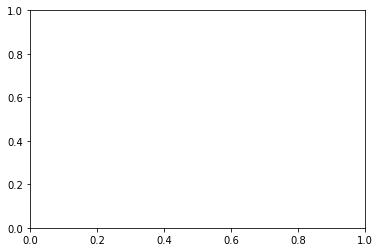

In [340]:
num_of_points = [5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29]
plt.scatter(num_of_points, correlations, color = "red")
plt.xlabel("Number of points used to plot Gradient")
plt.ylabel("Coorelation")
plt.ylim(min(correlations) - 0.0001, max(correlations) + 0.0001)
plt.axhline(correlations[15], alpha = 0.4)
plt.axvline(20, alpha = 0.4)
plt.title("Correlations against Number of points used")
plt.show()

### Choosing how many points to derive gradient from 

Based on the graph above, we can see that the coorelation increases  when more points are considered for the gradient. We decided to use 20 points to generate our gradient as it gives us a strong linear correlation with the water bath's temperature, and at the same time, using 20 data points (20 seconds) give us sufficient buffer before we cross the 25 seconds requirement during the actual prediction.

# Training Model

Using the gradients derived from 20 data points, we trained a linear model of Temperatures against Gradients. The model is saved using Pickle and loaded thereafter for inference and prediction. 

In [341]:
from sklearn import linear_model
regr = linear_model.LinearRegression()
x = [[gradient] for gradient in gradients]
y = [[real_temp] for real_temp in real_temps]
regr.fit(np.array(x), np.array(y))
regr.predict(0)

import pickle
s = pickle.dumps(regr)
clf = pickle.loads(s)

ValueError: Expected 2D array, got 1D array instead:
array=[].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

# Verification and Accuracy









In [342]:
import glob
files = glob.glob("TestingData/*")
print(files)
grads_test = []
real_temps_test = []
for file in files: 
    temps_ = []
    real_temp = float(file[17:21])
    real_temps_test.append(real_temp)
    f = open(file, 'r')
    
    for line in f: 
        t = float((line.split(' ')[0]))
        temps_.append(t)

    grad, intercept = find_gradient(temps_,20)
    grads_test.append(grad)
        
print(grads_test)
print(clf.predict([[grad] for grad in grads_test]))
print(real_temps_test)

['TestingData/test_54.1.txt', 'TestingData/test_35.1.txt', 'TestingData/test_25.1.txt', 'TestingData/test_39.6.txt']
[0.66875413533762296, 0.20001353383284171, -0.070542104965971658, 0.36221353383319554]
[[ 54.90246358]
 [ 35.78368571]
 [ 24.74838571]
 [ 42.39942533]]
[54.1, 35.1, 25.1, 39.6]


# Testing Using Instructor's Data

Instruction:

* Store your trained model into a pickle object which can be loaded. 
* Read an excel file with the following format:
```
time (s)	reading
0.00	    25.812
0.90	    28.562
1.79	    31.875
2.68	    35.062
3.55	    37.937
4.43	    40.687
5.30	    43.25
```
where the first column indicates the time in seconds and the second column indicates the sensor reading in Celsius. 
* The number of rows in the instructors' data can be of any number. If your code has a minimum number of rows, your code must be able to handle and exit safely when the data provided is less than the required minimum.
* Write a code to prepare the data for prediction.
* Write a code to predict the final temperature.



In [343]:
# write a code to load your trained model from a pickle object
import pickle
filename = '' # enter your pickle file name containing the model
with open(filename,'rb') as f:
    model = pickle.load(f)


FileNotFoundError: [Errno 2] No such file or directory: ''

In [ ]:
# write a code to read an excel file
import pandas as pd
num_test = 9
filename = 'temp_' 
filekey = [] # instructors will key in this
dataframe = {} # this is to store the data for different temperature, the keys are in filekey
for idx in range(num_test):
    dataframe[filekey[idx]] = pd.read_excel(filename+filekey[idx]+'.xlsx')


In [ ]:
# write a code to prepare the data for predicting
def preprocess(df):
    # use this function to extract the features from the data frame
    pass

data_test = {}
for key in filekey:
    data_test[key]=preprocess(dataframe[key])

In [ ]:
# write a code to predict the final temperature
# store the predicted temperature in a variable called "predicted"
# predicted is a dictionary where the keys are listed in filekey

predicted = {}
for key in filekey:
    predicted[key]=model.predict(data_test[key])

In [ ]:
# checking accuracy

# first instructor will load the actual temp from a pickle object
import pickle
error_d = {}
accuracy_percent_d = {}

for test in range(num_test):
    filename = 'data_'+filekey[test]+'.pickle'
    with open(filename,'rb') as f:
        final_temp, worst_temp = pickle.load(f)

    # then calculate the error
    error_final = abs(final_temp-predicted[filekey[test]])
    accuracy_final_percent = 100-error_final/final_temp*100
    error_worst = abs(worst_temp-predicted[filekey[test]])
    accuracy_worst_percent = 100-error_worst/worst_temp*100
    
    error_d[filekey[test]] = (error_final, error_worst)
    accuracy_percent_d[filekey[test]] = (accuracy_final_percent, accuracy_worst_percent)

    # displaying the error
    print('===================================')
    print('Testing: {}'.format(filekey[test]))
    print('Predicted Temp: {:.2f}'.format(predicted[filekey[test]]))
    print('Final Sensor Temp: {:.2f}, Alcohol Temp:{:.2f}'.format(final_temp, worst_temp))
    print('Error w.r.t Final Sensor Temp: {:.2f} deg, {:.2f}% accuracy'.format(error_final, accuracy_final_percent))
    print('Error w.r.t Alcohol Temp: {:.2f} deg, {:.2f}% accuracy'.format(error_worst, accuracy_worst_percent))
    
avg_final = sum([ final for final, worst in accuracy_percent_d.values()])/len(error_d.values())
avg_worst = sum([ worst for final, worst in accuracy_percent_d.values()])/len(error_d.values())
print('==============================')
print('Average accuracy for final sensor temp: {:.2f}'.format(avg_final))
print('AVerage accuracy for alcohol temp: {:.2f}'.format(avg_worst))
